In [1]:
# based on code from https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-onencoded_space_dim-mnist-dataset-d65145c132ac 

In [2]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random, os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
# class MapsDataset(torch.utils.data.Dataset):
#     def __init__(self, map_dir, transform=None, shape = (100,100)):
#         self.maps = []                                                  # create a list to hold all paths read from file
#         for filename in os.listdir(map_dir):
#             with open(os.path.join(map_dir, filename), 'r') as f:                                   # open in readonly mode
#                 self.flat_map = np.loadtxt(f)                                                   # load in the flat path from file
#                 self.map = np.asarray(self.flat_map, dtype=int).reshape(shape[0], shape[1])     # unflatten the map from the file
#                 self.maps.append(self.map)                              # add the path to paths list
#         self.transform = transform
#         print("Done!")

#     def __len__(self):
#         return len(self.maps)

#     def __getitem__(self, idx):
#         x = np.float32(self.maps[idx])

#         # if self.transform:
#         #     x = self.transform(x).cuda()

#         return x

In [4]:
class MapsDataset(torch.utils.data.Dataset):
    # init the dataset, shape = L x W
    def __init__(self, gen_dir, transform=None, shape = (100,100), device='cpu'):
        self.device = device
        self.maps = []

        num_maps = 0
        for directory in os.listdir(gen_dir):
            num_maps += 1
            dir_path = os.path.join(gen_dir, directory)

            # open map file:
            with open(f"{dir_path}/{directory}.txt", 'r') as f:
                self.flat_map = np.loadtxt(f)
                self.map = np.asarray(self.flat_map, dtype=np.float32).reshape(shape[0],shape[1])

                # add map to maps array:
                self.maps.append(self.map)

            # if num_maps == stop_after:
            #     break
        
        self.transform = transform
        print("Done!")

    def __len__(self):
        return len(self.maps)

    def __getitem__(self, idx):
        x = self.maps[idx]
        if self.transform:
            x = self.transform(x)
        
        return x

In [5]:
data_dir = 'dataset'

data_transform = transforms.Compose([
transforms.ToTensor(),
])

# dataset = MapsDataset(map_dir = f"./env/maps_size_64x64/", shape = (64,64), transform=data_transform)
train_dataset = MapsDataset(gen_dir = f"./env/random_multi_density/train/", shape = (64,64), transform=data_transform)
test_dataset = MapsDataset(gen_dir = f"./env/random_multi_density/eval/", shape = (64,64), transform=data_transform)

# m=len(dataset)
# train_dataset, test_dataset = random_split(dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

Done!
Done!


In [6]:
# # determine train dataset coverage %:
# perc_sum = 0
# for image_batch in train_loader:
    
#     obs_coords = np.transpose(torch.flipud(np.argwhere(torch.tensor(image_batch)==1)))
#     obs_perc = (len(obs_coords)/(64*64))
#     perc_sum += obs_perc

#     # plt.imshow(image_batch)
#     # plt.scatter(obs_coords[:,0], obs_coords[:,1])
#     # plt.show()
#     # break
# average_coverage = perc_sum/len(train_loader)*100
# print(f"Average coverage: {round(average_coverage, 2)}%")

In [7]:
FEATURE_ARR = [16,32,64,128] # [64,128,256,512]

In [8]:
class Encoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, FEATURE_ARR[0], 5, stride=2, padding=1),
            nn.BatchNorm2d(FEATURE_ARR[0]),
            nn.ReLU(True),
            nn.Conv2d(FEATURE_ARR[0], FEATURE_ARR[1], 5, stride=2, padding=1),
            nn.BatchNorm2d(FEATURE_ARR[1]),
            nn.ReLU(True),
            nn.Conv2d(FEATURE_ARR[1], FEATURE_ARR[2], 5, stride=2, padding=1),
            nn.BatchNorm2d(FEATURE_ARR[2]),
            nn.ReLU(True),     
            nn.Conv2d(FEATURE_ARR[2], FEATURE_ARR[3], 7, stride=2, padding=0),
            nn.BatchNorm2d(FEATURE_ARR[3]),
            nn.ReLU(True),  
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        return x

In [9]:
class Decoder(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(FEATURE_ARR[3], 1, 1))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(FEATURE_ARR[3], FEATURE_ARR[2], 7, 
            stride=2, padding=0, output_padding=0),
            nn.BatchNorm2d(FEATURE_ARR[2]),
            nn.ReLU(True),
            nn.ConvTranspose2d(FEATURE_ARR[2], FEATURE_ARR[1], 5, 
            stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(FEATURE_ARR[1]),
            nn.ReLU(True),
            nn.ConvTranspose2d(FEATURE_ARR[1], FEATURE_ARR[0], 5, 
            stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(FEATURE_ARR[0]),
            nn.ReLU(True),
            nn.ConvTranspose2d(FEATURE_ARR[0], 1, 5, 
            stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [10]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.000025

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

encoder = Encoder()
decoder = Decoder()
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr)#, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (unflatten): Unflatten(dim=1, unflattened_size=(128, 1, 1))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(7, 7), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [11]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader
    for batch_index, image_batch in enumerate(dataloader):
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        # image_batch = image_batch[:,None,:,:]
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [12]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for batch_index, image_batch in enumerate(dataloader):
            # Move tensor to the proper device
            # image_batch = image_batch[:,None,:,:]
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [13]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = torch.tensor(test_dataset[i]).unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   


 EPOCH 1/500 	 train loss 0.23933188617229462 	 val loss 0.23148967325687408


/tmp/ipykernel_22145/2746720105.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(test_dataset[i]).unsqueeze(0).to(device)


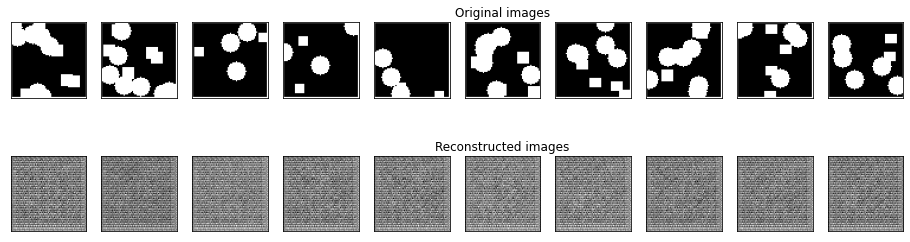


 EPOCH 2/500 	 train loss 0.22792650759220123 	 val loss 0.22031386196613312

 EPOCH 3/500 	 train loss 0.21745111048221588 	 val loss 0.21043123304843903

 EPOCH 4/500 	 train loss 0.20712395012378693 	 val loss 0.19846448302268982

 EPOCH 5/500 	 train loss 0.1972418576478958 	 val loss 0.1881105601787567

 EPOCH 6/500 	 train loss 0.18819184601306915 	 val loss 0.17905911803245544

 EPOCH 7/500 	 train loss 0.18014496564865112 	 val loss 0.1719166785478592

 EPOCH 8/500 	 train loss 0.17279505729675293 	 val loss 0.16570989787578583

 EPOCH 9/500 	 train loss 0.1658957451581955 	 val loss 0.1593390852212906

 EPOCH 10/500 	 train loss 0.1595030277967453 	 val loss 0.15378297865390778

 EPOCH 11/500 	 train loss 0.15342333912849426 	 val loss 0.14836961030960083

 EPOCH 12/500 	 train loss 0.14771215617656708 	 val loss 0.14320044219493866

 EPOCH 13/500 	 train loss 0.14218492805957794 	 val loss 0.13834421336650848

 EPOCH 14/500 	 train loss 0.1371861696243286 	 val loss 0.133715

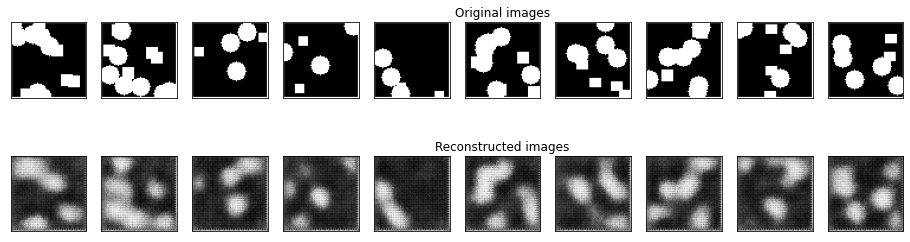


 EPOCH 27/500 	 train loss 0.09619402885437012 	 val loss 0.09696769714355469

 EPOCH 28/500 	 train loss 0.09424513578414917 	 val loss 0.09517400711774826

 EPOCH 29/500 	 train loss 0.09231328219175339 	 val loss 0.0935925617814064

 EPOCH 30/500 	 train loss 0.09061414003372192 	 val loss 0.09185110777616501

 EPOCH 31/500 	 train loss 0.08886092901229858 	 val loss 0.09033848345279694

 EPOCH 32/500 	 train loss 0.08722030371427536 	 val loss 0.08891931176185608

 EPOCH 33/500 	 train loss 0.08570178598165512 	 val loss 0.08727829158306122

 EPOCH 34/500 	 train loss 0.0841684564948082 	 val loss 0.08610613644123077

 EPOCH 35/500 	 train loss 0.08284302800893784 	 val loss 0.08469147235155106

 EPOCH 36/500 	 train loss 0.08143448829650879 	 val loss 0.08361480385065079

 EPOCH 37/500 	 train loss 0.08007270842790604 	 val loss 0.08237966895103455

 EPOCH 38/500 	 train loss 0.0788906067609787 	 val loss 0.08120608329772949

 EPOCH 39/500 	 train loss 0.07761391997337341 	 val l

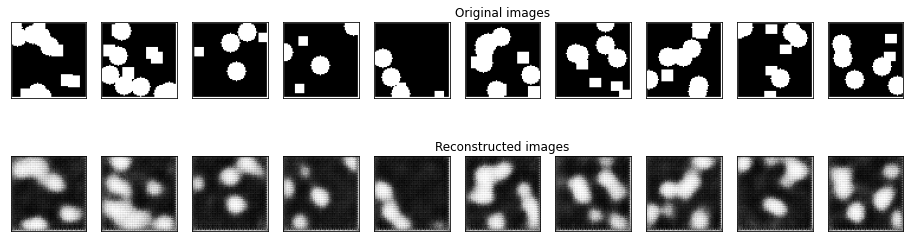


 EPOCH 52/500 	 train loss 0.0649939700961113 	 val loss 0.06870951503515244

 EPOCH 53/500 	 train loss 0.06414783000946045 	 val loss 0.06807450950145721

 EPOCH 54/500 	 train loss 0.06335166841745377 	 val loss 0.06755248457193375

 EPOCH 55/500 	 train loss 0.06273799389600754 	 val loss 0.06661565601825714

 EPOCH 56/500 	 train loss 0.061904292553663254 	 val loss 0.0661475732922554

 EPOCH 57/500 	 train loss 0.061325039714574814 	 val loss 0.06562067568302155

 EPOCH 58/500 	 train loss 0.0605057068169117 	 val loss 0.06530633568763733

 EPOCH 59/500 	 train loss 0.059913501143455505 	 val loss 0.06445353478193283

 EPOCH 60/500 	 train loss 0.05908212065696716 	 val loss 0.06393207609653473

 EPOCH 61/500 	 train loss 0.05851057171821594 	 val loss 0.06339845061302185

 EPOCH 62/500 	 train loss 0.0579669289290905 	 val loss 0.06286083906888962

 EPOCH 63/500 	 train loss 0.057381581515073776 	 val loss 0.06257019191980362

 EPOCH 64/500 	 train loss 0.05674773454666138 	 va

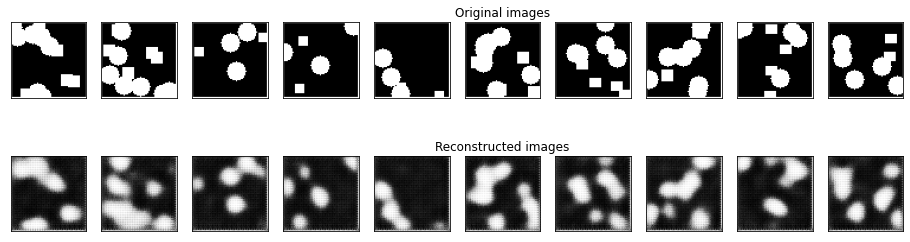


 EPOCH 77/500 	 train loss 0.050274789333343506 	 val loss 0.0567224845290184

 EPOCH 78/500 	 train loss 0.04977663233876228 	 val loss 0.05631405487656593

 EPOCH 79/500 	 train loss 0.049365703016519547 	 val loss 0.056156083941459656

 EPOCH 80/500 	 train loss 0.048927128314971924 	 val loss 0.05584031343460083

 EPOCH 81/500 	 train loss 0.048567939549684525 	 val loss 0.05563534423708916

 EPOCH 82/500 	 train loss 0.04815131425857544 	 val loss 0.055265478789806366

 EPOCH 83/500 	 train loss 0.04801302030682564 	 val loss 0.05497625842690468

 EPOCH 84/500 	 train loss 0.04736272990703583 	 val loss 0.05472332984209061

 EPOCH 85/500 	 train loss 0.04684458300471306 	 val loss 0.05444059893488884

 EPOCH 86/500 	 train loss 0.04672601819038391 	 val loss 0.05427594110369682

 EPOCH 87/500 	 train loss 0.04623571038246155 	 val loss 0.053956057876348495

 EPOCH 88/500 	 train loss 0.04593438282608986 	 val loss 0.05399831011891365

 EPOCH 89/500 	 train loss 0.0455500781536102

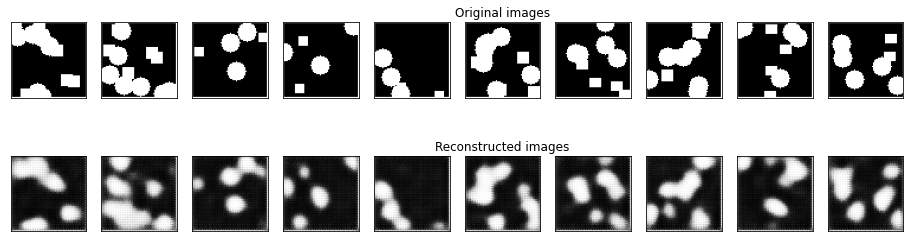


 EPOCH 102/500 	 train loss 0.041327763348817825 	 val loss 0.05035674199461937

 EPOCH 103/500 	 train loss 0.04111884906888008 	 val loss 0.05005986616015434

 EPOCH 104/500 	 train loss 0.0408279113471508 	 val loss 0.05037108436226845

 EPOCH 105/500 	 train loss 0.040685880929231644 	 val loss 0.049752216786146164

 EPOCH 106/500 	 train loss 0.04017837718129158 	 val loss 0.04945351555943489

 EPOCH 107/500 	 train loss 0.03997635468840599 	 val loss 0.049529146403074265

 EPOCH 108/500 	 train loss 0.039680834859609604 	 val loss 0.04952894151210785

 EPOCH 109/500 	 train loss 0.03940777853131294 	 val loss 0.04924576357007027

 EPOCH 110/500 	 train loss 0.039314448833465576 	 val loss 0.04905862733721733

 EPOCH 111/500 	 train loss 0.03922387585043907 	 val loss 0.0490419864654541

 EPOCH 112/500 	 train loss 0.03871955722570419 	 val loss 0.04879406839609146

 EPOCH 113/500 	 train loss 0.038516815751791 	 val loss 0.048477642238140106

 EPOCH 114/500 	 train loss 0.038161

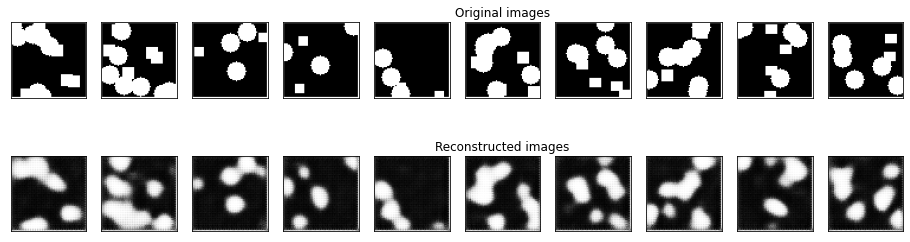


 EPOCH 127/500 	 train loss 0.0353248231112957 	 val loss 0.04685463756322861

 EPOCH 128/500 	 train loss 0.035159192979335785 	 val loss 0.0467146635055542

 EPOCH 129/500 	 train loss 0.03511115908622742 	 val loss 0.04665684700012207

 EPOCH 130/500 	 train loss 0.0347217321395874 	 val loss 0.046538811177015305

 EPOCH 131/500 	 train loss 0.03463885188102722 	 val loss 0.04628460109233856

 EPOCH 132/500 	 train loss 0.034481700509786606 	 val loss 0.04646313935518265

 EPOCH 133/500 	 train loss 0.03423402085900307 	 val loss 0.046044182032346725

 EPOCH 134/500 	 train loss 0.03409456089138985 	 val loss 0.04563065245747566

 EPOCH 135/500 	 train loss 0.03391158953309059 	 val loss 0.04580167680978775

 EPOCH 136/500 	 train loss 0.03352547809481621 	 val loss 0.0455332025885582

 EPOCH 137/500 	 train loss 0.03342771530151367 	 val loss 0.045601557940244675

 EPOCH 138/500 	 train loss 0.03342290595173836 	 val loss 0.04554752632975578

 EPOCH 139/500 	 train loss 0.03298338

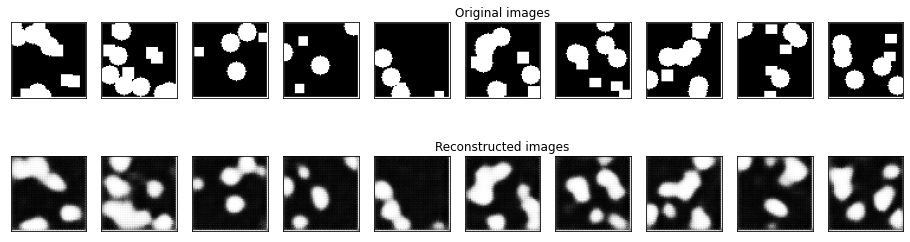


 EPOCH 152/500 	 train loss 0.031123435124754906 	 val loss 0.0447494275867939

 EPOCH 153/500 	 train loss 0.030758902430534363 	 val loss 0.04441867396235466

 EPOCH 154/500 	 train loss 0.030792945995926857 	 val loss 0.044620413333177567

 EPOCH 155/500 	 train loss 0.03043559193611145 	 val loss 0.044632673263549805

 EPOCH 156/500 	 train loss 0.030418455600738525 	 val loss 0.04435619339346886

 EPOCH 157/500 	 train loss 0.030184611678123474 	 val loss 0.04420345649123192

 EPOCH 158/500 	 train loss 0.030055977404117584 	 val loss 0.04406910762190819

 EPOCH 159/500 	 train loss 0.029948094859719276 	 val loss 0.04422023519873619

 EPOCH 160/500 	 train loss 0.02986862324178219 	 val loss 0.044136397540569305

 EPOCH 161/500 	 train loss 0.029734959825873375 	 val loss 0.043998684734106064

 EPOCH 162/500 	 train loss 0.029700493440032005 	 val loss 0.04375937208533287

 EPOCH 163/500 	 train loss 0.029350819066166878 	 val loss 0.04390011727809906

 EPOCH 164/500 	 train los

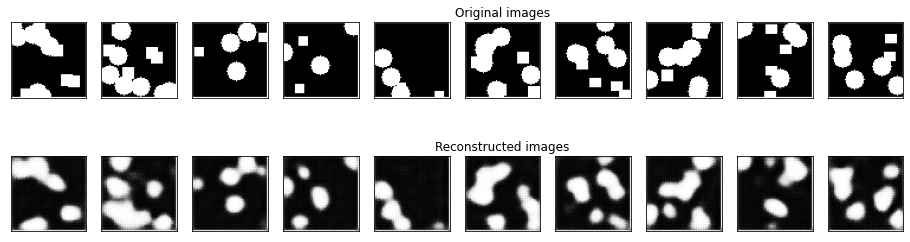


 EPOCH 177/500 	 train loss 0.02785525657236576 	 val loss 0.04293769225478172

 EPOCH 178/500 	 train loss 0.02761358954012394 	 val loss 0.04332801327109337

 EPOCH 179/500 	 train loss 0.027535559609532356 	 val loss 0.042903006076812744

 EPOCH 180/500 	 train loss 0.027362912893295288 	 val loss 0.04288195073604584

 EPOCH 181/500 	 train loss 0.027287987992167473 	 val loss 0.04249400272965431

 EPOCH 182/500 	 train loss 0.02728661708533764 	 val loss 0.042939282953739166

 EPOCH 183/500 	 train loss 0.026905061677098274 	 val loss 0.0427851602435112

 EPOCH 184/500 	 train loss 0.0268248338252306 	 val loss 0.04282963275909424

 EPOCH 185/500 	 train loss 0.026653459295630455 	 val loss 0.04270516335964203

 EPOCH 186/500 	 train loss 0.02672501467168331 	 val loss 0.04274342954158783

 EPOCH 187/500 	 train loss 0.02667500264942646 	 val loss 0.0426395982503891

 EPOCH 188/500 	 train loss 0.026556506752967834 	 val loss 0.042527250945568085

 EPOCH 189/500 	 train loss 0.026

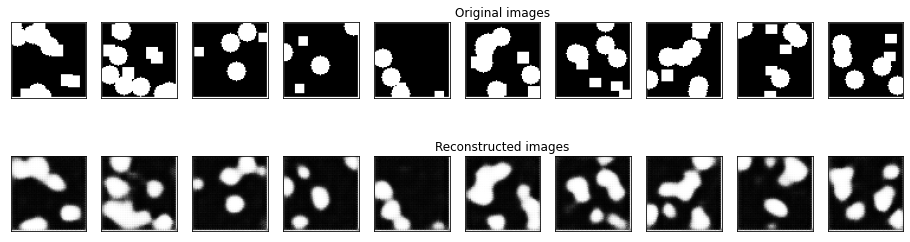


 EPOCH 202/500 	 train loss 0.02510564588010311 	 val loss 0.042312417179346085

 EPOCH 203/500 	 train loss 0.024917596951127052 	 val loss 0.042117729783058167

 EPOCH 204/500 	 train loss 0.024938976392149925 	 val loss 0.041742559522390366

 EPOCH 205/500 	 train loss 0.02487185038626194 	 val loss 0.04211929813027382

 EPOCH 206/500 	 train loss 0.024799058213829994 	 val loss 0.041852060705423355

 EPOCH 207/500 	 train loss 0.02457265369594097 	 val loss 0.04205365106463432

 EPOCH 208/500 	 train loss 0.024601906538009644 	 val loss 0.04223607853055

 EPOCH 209/500 	 train loss 0.024501537904143333 	 val loss 0.04213126376271248

 EPOCH 210/500 	 train loss 0.02445056103169918 	 val loss 0.042410168796777725

 EPOCH 211/500 	 train loss 0.024341722950339317 	 val loss 0.041824840009212494

 EPOCH 212/500 	 train loss 0.024254510179162025 	 val loss 0.04205133765935898

 EPOCH 213/500 	 train loss 0.02412443608045578 	 val loss 0.0415557362139225

 EPOCH 214/500 	 train loss 0.

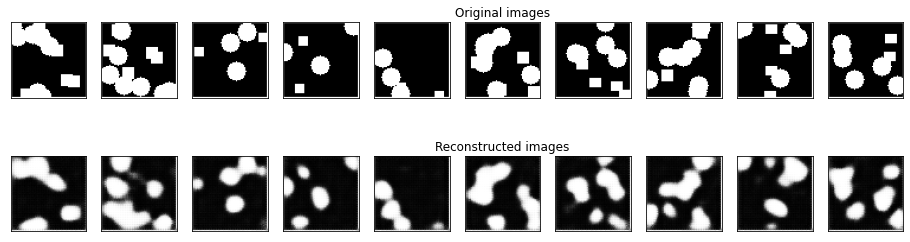


 EPOCH 227/500 	 train loss 0.023089198395609856 	 val loss 0.0416782982647419

 EPOCH 228/500 	 train loss 0.02303254045546055 	 val loss 0.04156731441617012

 EPOCH 229/500 	 train loss 0.023087428882718086 	 val loss 0.04157067462801933

 EPOCH 230/500 	 train loss 0.023163625970482826 	 val loss 0.04137006774544716

 EPOCH 231/500 	 train loss 0.02287081815302372 	 val loss 0.041626885533332825

 EPOCH 232/500 	 train loss 0.022671574726700783 	 val loss 0.04168916121125221

 EPOCH 233/500 	 train loss 0.022758223116397858 	 val loss 0.041616614907979965

 EPOCH 234/500 	 train loss 0.022508978843688965 	 val loss 0.0415714792907238

 EPOCH 235/500 	 train loss 0.02259349822998047 	 val loss 0.0413842536509037

 EPOCH 236/500 	 train loss 0.02266070246696472 	 val loss 0.04131725803017616

 EPOCH 237/500 	 train loss 0.022572392597794533 	 val loss 0.04129418358206749

 EPOCH 238/500 	 train loss 0.022301683202385902 	 val loss 0.04118034988641739

 EPOCH 239/500 	 train loss 0.02

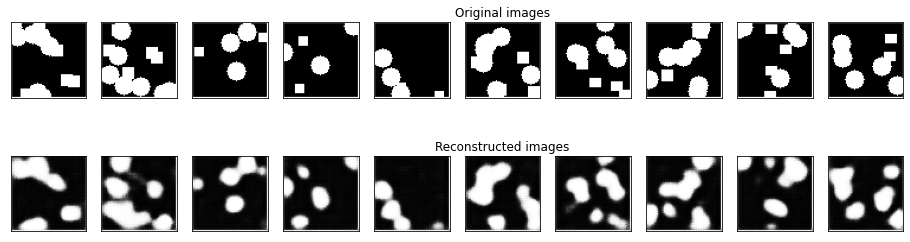


 EPOCH 252/500 	 train loss 0.021661700680851936 	 val loss 0.04145174100995064

 EPOCH 253/500 	 train loss 0.02152934856712818 	 val loss 0.04134673997759819

 EPOCH 254/500 	 train loss 0.0212391447275877 	 val loss 0.04131415858864784

 EPOCH 255/500 	 train loss 0.021287405863404274 	 val loss 0.04136136546730995

 EPOCH 256/500 	 train loss 0.021298907697200775 	 val loss 0.041530631482601166

 EPOCH 257/500 	 train loss 0.02130075730383396 	 val loss 0.041534192860126495

 EPOCH 258/500 	 train loss 0.021142372861504555 	 val loss 0.04168310388922691

 EPOCH 259/500 	 train loss 0.021152859553694725 	 val loss 0.04190225526690483

 EPOCH 260/500 	 train loss 0.021049082279205322 	 val loss 0.0415617935359478

 EPOCH 261/500 	 train loss 0.020952874794602394 	 val loss 0.04148323833942413

 EPOCH 262/500 	 train loss 0.02082175761461258 	 val loss 0.04132961109280586

 EPOCH 263/500 	 train loss 0.020735634490847588 	 val loss 0.04136035591363907

 EPOCH 264/500 	 train loss 0.0

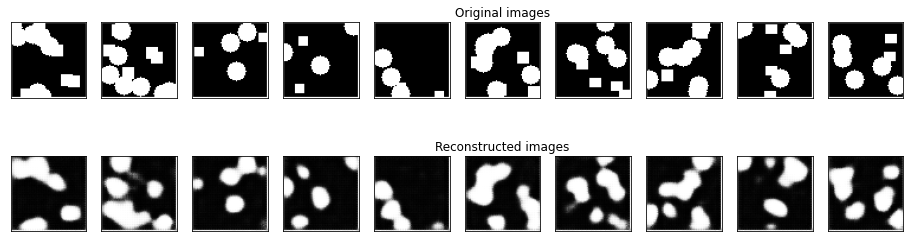


 EPOCH 277/500 	 train loss 0.020080192014575005 	 val loss 0.04160033538937569

 EPOCH 278/500 	 train loss 0.01992097683250904 	 val loss 0.04175775498151779

 EPOCH 279/500 	 train loss 0.01985681988298893 	 val loss 0.04140772297978401

 EPOCH 280/500 	 train loss 0.020251639187335968 	 val loss 0.04163414612412453

 EPOCH 281/500 	 train loss 0.020027238875627518 	 val loss 0.04198576509952545

 EPOCH 282/500 	 train loss 0.019790291786193848 	 val loss 0.04159066826105118

 EPOCH 283/500 	 train loss 0.01986807957291603 	 val loss 0.041648395359516144

 EPOCH 284/500 	 train loss 0.019978446885943413 	 val loss 0.0417214073240757

 EPOCH 285/500 	 train loss 0.01983398199081421 	 val loss 0.04169176518917084

 EPOCH 286/500 	 train loss 0.01985803432762623 	 val loss 0.04194943979382515

 EPOCH 287/500 	 train loss 0.01982909068465233 	 val loss 0.0420987568795681

 EPOCH 288/500 	 train loss 0.01959642581641674 	 val loss 0.04175042733550072

 EPOCH 289/500 	 train loss 0.01962

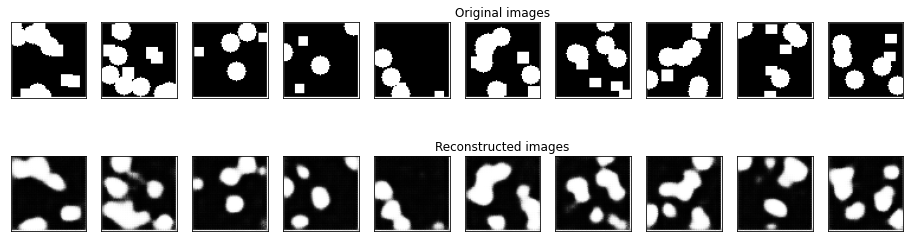


 EPOCH 302/500 	 train loss 0.01909315399825573 	 val loss 0.04214515537023544

 EPOCH 303/500 	 train loss 0.018997713923454285 	 val loss 0.04191512241959572

 EPOCH 304/500 	 train loss 0.018938012421131134 	 val loss 0.041736483573913574

 EPOCH 305/500 	 train loss 0.01871168427169323 	 val loss 0.041655752807855606

 EPOCH 306/500 	 train loss 0.018792511895298958 	 val loss 0.041723981499671936

 EPOCH 307/500 	 train loss 0.018905287608504295 	 val loss 0.041585009545087814

 EPOCH 308/500 	 train loss 0.018721824511885643 	 val loss 0.04206622764468193

 EPOCH 309/500 	 train loss 0.018619311973452568 	 val loss 0.042158614844083786

 EPOCH 310/500 	 train loss 0.018736595287919044 	 val loss 0.0417901985347271

 EPOCH 311/500 	 train loss 0.018874606117606163 	 val loss 0.041750624775886536

 EPOCH 312/500 	 train loss 0.01842590607702732 	 val loss 0.04206704720854759

 EPOCH 313/500 	 train loss 0.018550453707575798 	 val loss 0.04163423553109169

 EPOCH 314/500 	 train lo

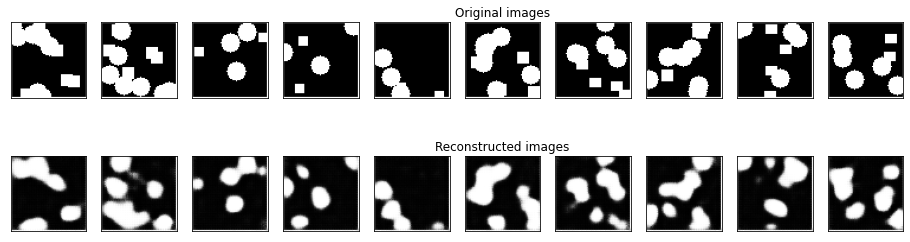


 EPOCH 327/500 	 train loss 0.018071934580802917 	 val loss 0.041696302592754364

 EPOCH 328/500 	 train loss 0.01793324202299118 	 val loss 0.041883684694767

 EPOCH 329/500 	 train loss 0.0181010439991951 	 val loss 0.04197096824645996

 EPOCH 330/500 	 train loss 0.017891891300678253 	 val loss 0.042022086679935455

 EPOCH 331/500 	 train loss 0.018103614449501038 	 val loss 0.04190758615732193

 EPOCH 332/500 	 train loss 0.0179190281778574 	 val loss 0.04189326986670494

 EPOCH 333/500 	 train loss 0.01791367307305336 	 val loss 0.042367856949567795

 EPOCH 334/500 	 train loss 0.017825759947299957 	 val loss 0.04203089326620102

 EPOCH 335/500 	 train loss 0.01768723875284195 	 val loss 0.04220862686634064

 EPOCH 336/500 	 train loss 0.017578810453414917 	 val loss 0.04184365272521973

 EPOCH 337/500 	 train loss 0.017602408304810524 	 val loss 0.0419214703142643

 EPOCH 338/500 	 train loss 0.01762889139354229 	 val loss 0.04200853034853935

 EPOCH 339/500 	 train loss 0.01754

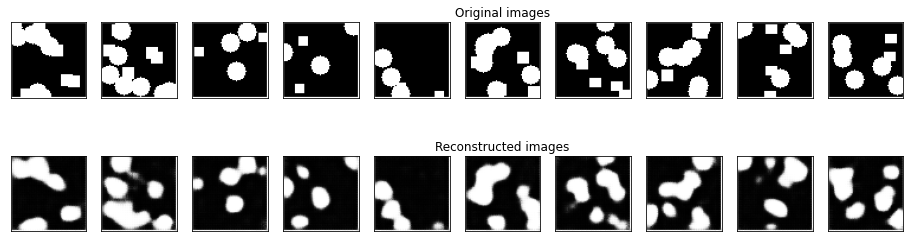


 EPOCH 352/500 	 train loss 0.017136016860604286 	 val loss 0.042632199823856354

 EPOCH 353/500 	 train loss 0.017251376062631607 	 val loss 0.04224032536149025

 EPOCH 354/500 	 train loss 0.016946202144026756 	 val loss 0.042389072477817535

 EPOCH 355/500 	 train loss 0.017125507816672325 	 val loss 0.04239876940846443

 EPOCH 356/500 	 train loss 0.016952143982052803 	 val loss 0.042584989219903946

 EPOCH 357/500 	 train loss 0.01708853431046009 	 val loss 0.0423964187502861

 EPOCH 358/500 	 train loss 0.017201192677021027 	 val loss 0.042446430772542953

 EPOCH 359/500 	 train loss 0.016892535611987114 	 val loss 0.04240326210856438

 EPOCH 360/500 	 train loss 0.016935570165514946 	 val loss 0.04210551455616951

 EPOCH 361/500 	 train loss 0.01682163216173649 	 val loss 0.042604610323905945

 EPOCH 362/500 	 train loss 0.016687730327248573 	 val loss 0.042515527456998825

 EPOCH 363/500 	 train loss 0.017049910500645638 	 val loss 0.042276185005903244

 EPOCH 364/500 	 train 

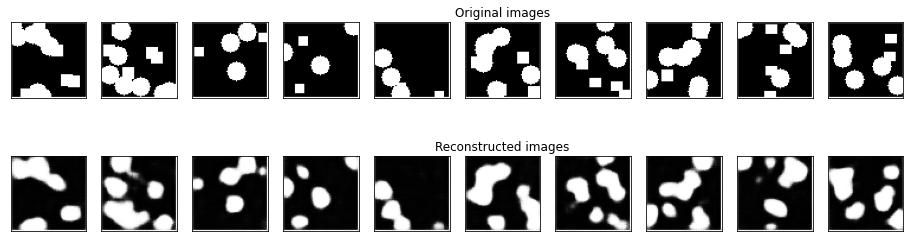


 EPOCH 377/500 	 train loss 0.016231447458267212 	 val loss 0.04281262680888176

 EPOCH 378/500 	 train loss 0.016463423147797585 	 val loss 0.042533885687589645

 EPOCH 379/500 	 train loss 0.016382800415158272 	 val loss 0.04261234775185585

 EPOCH 380/500 	 train loss 0.016550324857234955 	 val loss 0.04299938678741455

 EPOCH 381/500 	 train loss 0.01664487086236477 	 val loss 0.043341971933841705

 EPOCH 382/500 	 train loss 0.016581954434514046 	 val loss 0.04304398223757744

 EPOCH 383/500 	 train loss 0.016450075432658195 	 val loss 0.04284735769033432

 EPOCH 384/500 	 train loss 0.01638241671025753 	 val loss 0.04314398393034935

 EPOCH 385/500 	 train loss 0.01638345792889595 	 val loss 0.04270293191075325

 EPOCH 386/500 	 train loss 0.016412027180194855 	 val loss 0.04272405058145523

 EPOCH 387/500 	 train loss 0.01625392585992813 	 val loss 0.042916689068078995

 EPOCH 388/500 	 train loss 0.016288606449961662 	 val loss 0.042676687240600586

 EPOCH 389/500 	 train loss

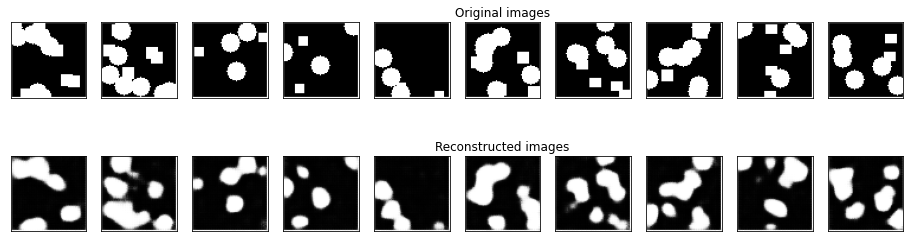


 EPOCH 402/500 	 train loss 0.01619262807071209 	 val loss 0.04273463040590286

 EPOCH 403/500 	 train loss 0.015798592939972878 	 val loss 0.04294189438223839

 EPOCH 404/500 	 train loss 0.01595039665699005 	 val loss 0.04301512986421585

 EPOCH 405/500 	 train loss 0.015577897429466248 	 val loss 0.04314780980348587

 EPOCH 406/500 	 train loss 0.015816153958439827 	 val loss 0.04298124089837074

 EPOCH 407/500 	 train loss 0.015643097460269928 	 val loss 0.043168529868125916

 EPOCH 408/500 	 train loss 0.015616941265761852 	 val loss 0.042924873530864716

 EPOCH 409/500 	 train loss 0.015775345265865326 	 val loss 0.04279104992747307

 EPOCH 410/500 	 train loss 0.015759697183966637 	 val loss 0.04300438612699509

 EPOCH 411/500 	 train loss 0.015607662498950958 	 val loss 0.04316403716802597

 EPOCH 412/500 	 train loss 0.01576216332614422 	 val loss 0.04286869987845421

 EPOCH 413/500 	 train loss 0.015594236552715302 	 val loss 0.04325542971491814

 EPOCH 414/500 	 train loss 

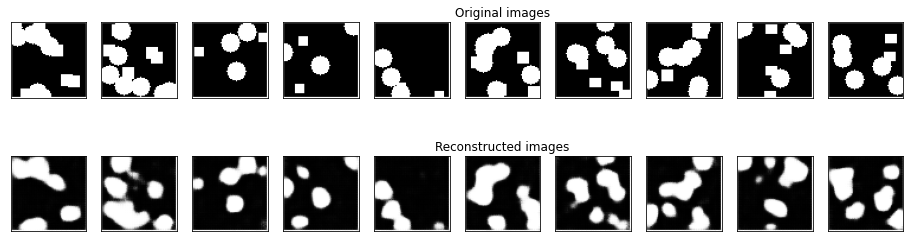


 EPOCH 427/500 	 train loss 0.015263413079082966 	 val loss 0.043275512754917145

 EPOCH 428/500 	 train loss 0.015382777899503708 	 val loss 0.043355926871299744

 EPOCH 429/500 	 train loss 0.015421289019286633 	 val loss 0.04385131224989891

 EPOCH 430/500 	 train loss 0.015471946448087692 	 val loss 0.04398402199149132

 EPOCH 431/500 	 train loss 0.015161529183387756 	 val loss 0.04369096830487251

 EPOCH 432/500 	 train loss 0.015531462617218494 	 val loss 0.04328841343522072

 EPOCH 433/500 	 train loss 0.015122651122510433 	 val loss 0.04305955395102501

 EPOCH 434/500 	 train loss 0.015190252102911472 	 val loss 0.04363701120018959

 EPOCH 435/500 	 train loss 0.015278357081115246 	 val loss 0.04332813248038292

 EPOCH 436/500 	 train loss 0.01510496437549591 	 val loss 0.0435473807156086

 EPOCH 437/500 	 train loss 0.01542283222079277 	 val loss 0.04327743873000145

 EPOCH 438/500 	 train loss 0.01514742523431778 	 val loss 0.043736234307289124

 EPOCH 439/500 	 train loss 

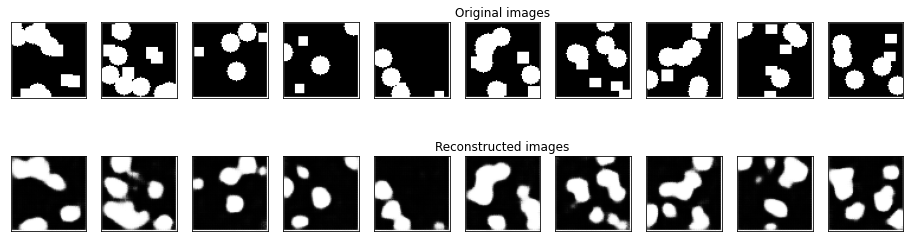


 EPOCH 452/500 	 train loss 0.014908578246831894 	 val loss 0.043736569583415985

 EPOCH 453/500 	 train loss 0.014985109679400921 	 val loss 0.04386018216609955

 EPOCH 454/500 	 train loss 0.0149270324036479 	 val loss 0.043884214013814926

 EPOCH 455/500 	 train loss 0.01474230270832777 	 val loss 0.0435287244617939

 EPOCH 456/500 	 train loss 0.014892895705997944 	 val loss 0.04333098605275154

 EPOCH 457/500 	 train loss 0.015065319836139679 	 val loss 0.043714750558137894

 EPOCH 458/500 	 train loss 0.015050274319946766 	 val loss 0.04379316791892052

 EPOCH 459/500 	 train loss 0.014965017326176167 	 val loss 0.04359817877411842

 EPOCH 460/500 	 train loss 0.014816303737461567 	 val loss 0.043623749166727066

 EPOCH 461/500 	 train loss 0.014765024185180664 	 val loss 0.0439445823431015

 EPOCH 462/500 	 train loss 0.014758482575416565 	 val loss 0.04406766965985298

 EPOCH 463/500 	 train loss 0.014799907803535461 	 val loss 0.044447850435972214

 EPOCH 464/500 	 train loss

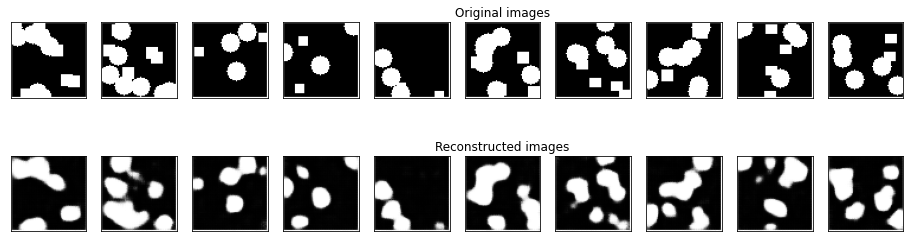


 EPOCH 477/500 	 train loss 0.014456786215305328 	 val loss 0.044683001935482025

 EPOCH 478/500 	 train loss 0.014313152991235256 	 val loss 0.04390254244208336

 EPOCH 479/500 	 train loss 0.014521107077598572 	 val loss 0.044120874255895615

 EPOCH 480/500 	 train loss 0.014578253030776978 	 val loss 0.04399251192808151

 EPOCH 481/500 	 train loss 0.014269358478486538 	 val loss 0.04435177519917488

 EPOCH 482/500 	 train loss 0.014363518916070461 	 val loss 0.044067010283470154

 EPOCH 483/500 	 train loss 0.014565207995474339 	 val loss 0.04459252208471298

 EPOCH 484/500 	 train loss 0.014274343848228455 	 val loss 0.044137533754110336

 EPOCH 485/500 	 train loss 0.014201696962118149 	 val loss 0.04398905485868454

 EPOCH 486/500 	 train loss 0.014204015024006367 	 val loss 0.043719712644815445

 EPOCH 487/500 	 train loss 0.014200172387063503 	 val loss 0.044149912893772125

 EPOCH 488/500 	 train loss 0.01414598897099495 	 val loss 0.04430190473794937

 EPOCH 489/500 	 train

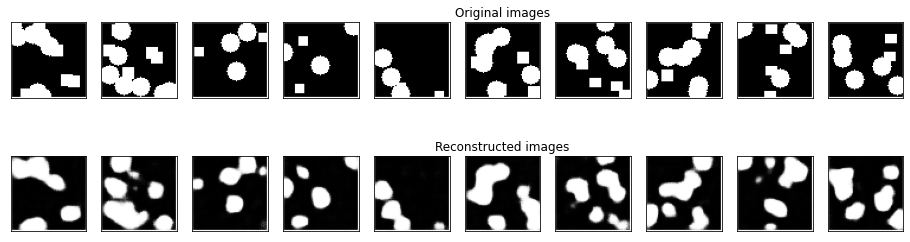

In [14]:

num_epochs = 500
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss = train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   if epoch % 25 == 0:
      plot_ae_outputs(encoder,decoder,n=10)
plot_ae_outputs(encoder,decoder,n=10)

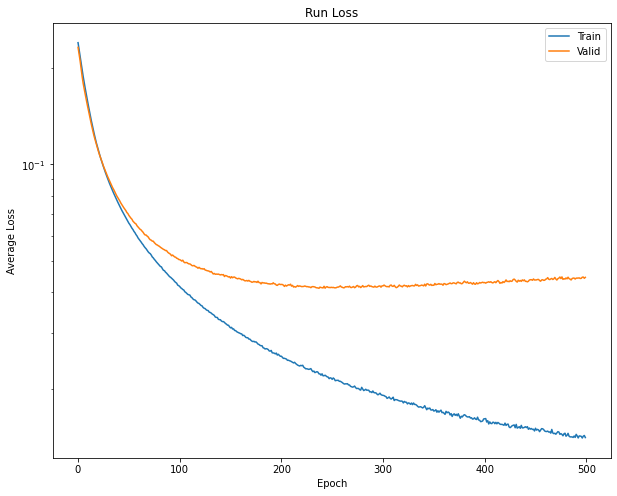

In [15]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
# plt.grid()
plt.legend()
plt.title('Run Loss')
plt.show()

In [16]:
# save encoder and decoder

SAVE = True
ENCODER_PATH = "checkpoints/encoder/"
DECODER_PATH = "checkpoints/decoder/"

if SAVE:
    torch.save({
                'model_state_dict': encoder.state_dict(),
    }, f"{ENCODER_PATH}epoch-{epoch}.tar")
    torch.save({
                'model_state_dict': decoder.state_dict(),
    }, f"{DECODER_PATH}epoch-{epoch}.tar")

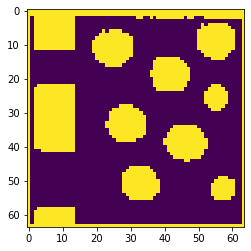

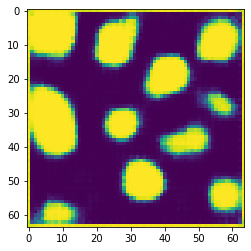

In [17]:
# example using encoder/decoder on loaded map

flat_map = np.loadtxt("env/test_map.txt", skiprows=2)                                                   # load in the flat path from file
map = torch.tensor(np.asarray(flat_map, dtype=int).reshape(64, 64)).to(device, dtype=torch.float)     # unflatten the map from the file

plt.imshow(map.cpu())
plt.show()

map_4d = map.unsqueeze(0).unsqueeze(0)

encoded_map = encoder(map_4d)
decoded_map = decoder(encoded_map)

new_map_2d = decoded_map.squeeze()

plt.imshow(new_map_2d.cpu().detach().numpy())
plt.show()